In [164]:
!chmod 600 /content/kaggle.json

In [165]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d datatattle/covid-19-nlp-text-classification

covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [166]:
import zipfile
zip_file = zipfile.ZipFile('/content/covid-19-nlp-text-classification.zip')
zip_file.extractall('/tmp/')

In [167]:
import pandas as pd

df_train = pd.read_csv('/tmp/Corona_NLP_train.csv', encoding='latin-1')
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [168]:
import pandas as pd

df_test = pd.read_csv('/tmp/Corona_NLP_test.csv', encoding='latin-1')
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

!pip install tensorflow-addons
import tensorflow_addons as tfa
import re

!pip install tweet-preprocessor
import preprocessor as p
import string
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


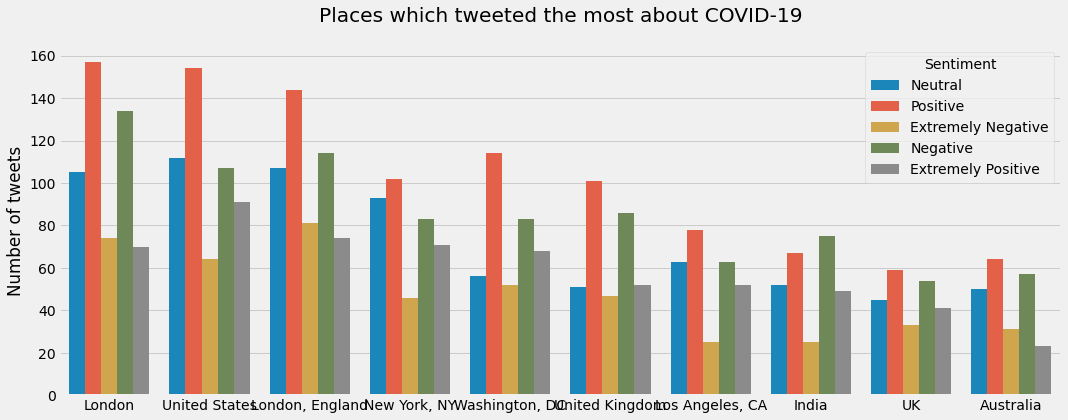

In [170]:
plt.style.use("fivethirtyeight")

plt.figure(figsize=(16, 6))
location = sns.countplot(x= 'Location', data= df_train, hue="Sentiment", order=df_train.Location.value_counts()[:10].index)
location.set_title("Places which tweeted the most about COVID-19", y=1.05)

def axis_labels(ax):
    ax.set_ylabel("Number of tweets")
    ax.set_xlabel("")

axis_labels(location)

plt.show()

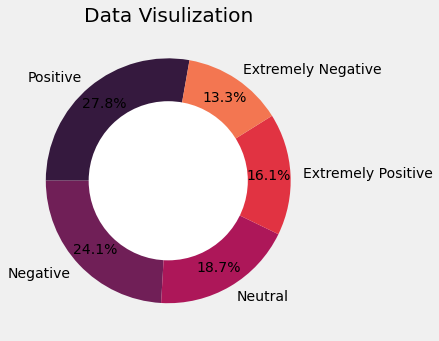

In [171]:
plt.figure(figsize=(6,6))

sentiments = df_train.Sentiment.value_counts()

sns.set_palette("rocket")
plt.pie(sentiments,
        labels= sentiments.index,
        autopct='%1.1f%%', startangle=80, 
        pctdistance=0.82, textprops={"fontsize": 14})

centreCircle = plt.Circle((0,0),0.65,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)

plt.tight_layout()
plt.title("Data Visulization")

plt.show()

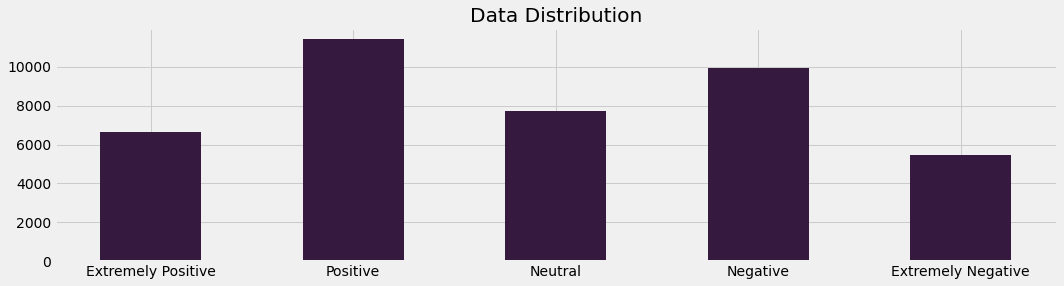

18046 7713 15398


In [172]:
ps = PorterStemmer()
df_train.head()

list_x = []
list_y = []

special_character = re.compile('[^0-9a-z #+_]')
special_symbol = re.compile('[/(){}\[\]\|@,;]')

stopping_words = set(stopwords.words('english'))

total_extreme_positive = 0
total_positive = 0
total_neutral = 0
total_negative = 0
total_extreme_negative = 0

pattern=r'[$+0-9]'

for _, data in df_train.iterrows():
  text = p.clean(data[4])
  text = text.split(' ')
  
  temp_str = ''
  
  for j in range(len(text)):
    temp_str += ' '+ps.stem(text[j])
  text = temp_str.strip()
  text = special_character.sub('', text)
  text = special_symbol.sub(' ', text)
  text = re.sub(pattern,'', text)
  text = ' '.join(word for word in text.split() if word not in stopping_words)

  list_x.append(text)
  new_str = ''

  if(data[5] == 'Positive'):
    total_positive += 1
  elif(data[5] == 'Negative'):
    total_negative += 1

  if(data[5] == 'Extremely Positive'):
    total_extreme_positive += 1
    new_str = 'Positive'
  elif(data[5] == 'Neutral'):
    total_neutral += 1
    new_str = data[5]
  elif(data[5] == 'Extremely Negative'):
    total_extreme_negative += 1
    new_str = 'Negative'
  else:
    new_str = data[5]

  list_y.append(new_str)
  
mixing_positive = total_extreme_positive + total_positive
mixing_negative = total_extreme_negative + total_negative

fig = plt.figure(figsize=(16, 4))
plt.bar(x=['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'],
        height=[total_extreme_positive, total_positive, total_neutral, total_negative, total_extreme_negative],
        width=0.5)
plt.title('Data Distribution')
plt.show()

print(mixing_positive, total_neutral, mixing_negative)

(23139,)
(23139,)


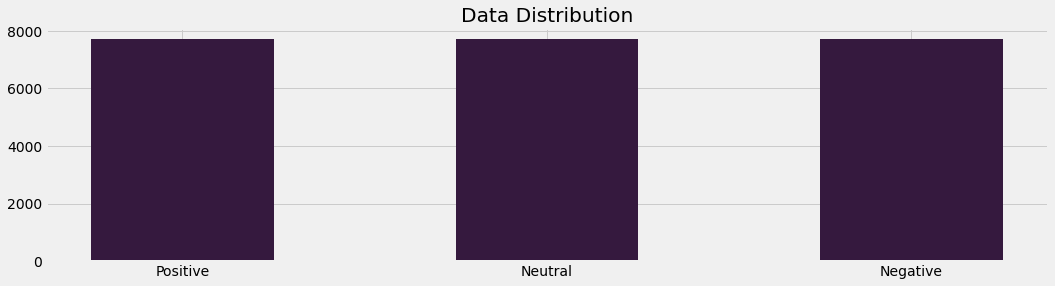

In [173]:
result_positive = 0
result_neutral = 0
result_negative = 0

list_train = []
list_label = []

for i in range(len(list_x)):
  add_list = 0
  if( total_neutral > result_positive and list_y[i] == 'Positive'):
    add_list = 1
    result_positive += 1
  if(total_neutral  > result_negative and list_y[i] == 'Negative'):
    add_list = 1
    result_negative += 1
  if(total_neutral > result_neutral and list_y[i] == 'Neutral'):
    add_list = 1
    result_neutral += 1
  if(add_list == 1):
    list_train.append(list_x[i])
    list_label.append(list_y[i])

result_train = np.array(list_train)
result_label = np.array(list_label)

print(result_train.shape)
print(result_label.shape)

fig = plt.figure(figsize=(16, 4))
plt.bar(x=['Positive', 'Neutral', 'Negative'],
        height=[result_positive, result_neutral, result_negative],
        width=0.5)
plt.title('Data Distribution')
plt.show()

In [174]:
df_train.Location = df_train.Location.str.split(',').str[0]

df_train["Sentiment"] = df_train["Sentiment"].str.replace("Extremely Negative", "Negative")
df_train["Sentiment"] = df_train["Sentiment"].str.replace("Extremely Positive", "Positive")

df_test['Sentiment'] = df_test.Sentiment.str.replace('Extremely Positive', 'Positive')
df_test['Sentiment'] = df_test.Sentiment.str.replace('Extremely Negative', 'Negative')

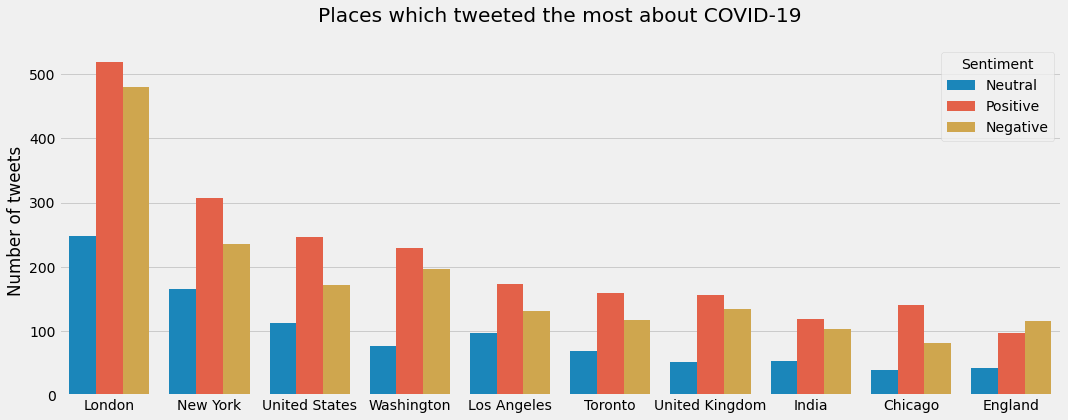

In [175]:
plt.style.use("fivethirtyeight")

plt.figure(figsize=(16, 6))
location = sns.countplot(x= 'Location', data= df_train, hue="Sentiment", order=df_train.Location.value_counts()[:10].index)
location.set_title("Places which tweeted the most about COVID-19", y=1.05)

def axis_labels(ax):
    ax.set_ylabel("Number of tweets")
    ax.set_xlabel("")

axis_labels(location)

plt.show()

In [176]:
from sklearn.preprocessing import LabelEncoder

content_list = []

for i in range(len(result_train)):
  content_list.append(result_train[i].split(' '))

print(result_train)
print(result_label)

max_pad_len = 0
for i in range(len(content_list)):
  if(max_pad_len < len(content_list[i])):
    max_pad_len = len(content_list[i])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(result_train) 

vocab_size = len(tokenizer.word_index) + 1
sekuens = tokenizer.texts_to_sequences(result_train)
padded = pad_sequences(sekuens, maxlen = max_pad_len, padding='post') 

labelencoder = LabelEncoder()
labelling = labelencoder.fit_transform(result_label)
label = tf.keras.utils.to_categorical(labelling)

x_train, x_test, y_train, y_test = train_test_split(padded, label, test_size=0.2, shuffle=True)

print(x_train)
print(y_train)

[''
 'advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order'
 'coronaviru australia woolworth give elderly disabl dedic shop hour amid covid outbreak'
 ... 'doe supermarket nearbi get covid'
 'airlin pilot offer stock supermarket shelv lockdown'
 'wrong smell hand sanit start turn']
['Neutral' 'Positive' 'Positive' ... 'Neutral' 'Neutral' 'Neutral']
[[ 171 1107  695 ...    0    0    0]
 [   8    3   31 ...    0    0    0]
 [  36 2333    6 ...    0    0    0]
 ...
 [  84  660  430 ...    0    0    0]
 [1718  184  170 ...    0    0    0]
 [ 121  663   17 ...    0    0    0]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [177]:
print(x_train.shape)

(18511, 38)


In [178]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length = max_pad_len),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    
    tf.keras.layers.BatchNormalization(axis = 1),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout = 0.5)),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.5),
    
    # tf.keras.layers.Dense(32),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 38, 64)            1629888   
                                                                 
 dropout_47 (Dropout)        (None, 38, 64)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 34, 128)           41088     
                                                                 
 batch_normalization_12 (Bat  (None, 34, 128)          136       
 chNormalization)                                                
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 8, 128)           0         
 g1D)                                                            
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)            

In [179]:
# callback
class historyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('val_accuracy') > 0.90 and logs.get('accuracy')>0.90):
      print('\n The Accuracy up to 90%, and forced to stop!')
      self.model.stop_training = True

callbacks = historyCallback()

In [180]:
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test),
                    epochs = 30,
                    batch_size = 128,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/30
145/145 [==============================] - 39s 208ms/step - loss: 1.0668 - accuracy: 0.4458 - val_loss: 1.0677 - val_accuracy: 0.4823
Epoch 2/30
145/145 [==============================] - 21s 142ms/step - loss: 0.8693 - accuracy: 0.6050 - val_loss: 0.8976 - val_accuracy: 0.6022
Epoch 3/30
145/145 [==============================] - 19s 133ms/step - loss: 0.6132 - accuracy: 0.7773 - val_loss: 0.6641 - val_accuracy: 0.7208
Epoch 4/30
145/145 [==============================] - 20s 138ms/step - loss: 0.4585 - accuracy: 0.8480 - val_loss: 0.6207 - val_accuracy: 0.7867
Epoch 5/30
145/145 [==============================] - 19s 134ms/step - loss: 0.3677 - accuracy: 0.8807 - val_loss: 0.6752 - val_accuracy: 0.7973
Epoch 6/30
145/145 [==============================] - 21s 143ms/step - loss: 0.3149 - accuracy: 0.8979 - val_loss: 0.8096 - val_accuracy: 0.7934
Epoch 7/30
145/145 [==============================] - 19s 133ms/step - loss: 0.2608 - accuracy: 0.9172 - val_loss: 0.9279 - val_ac

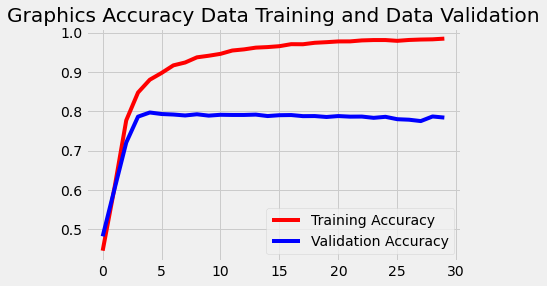

<Figure size 432x288 with 0 Axes>

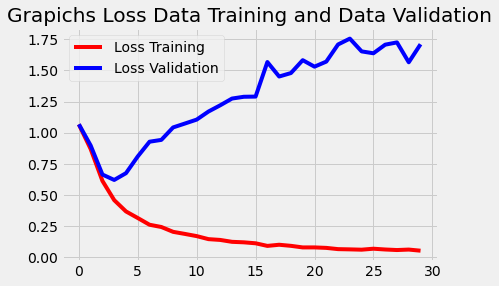

<Figure size 432x288 with 0 Axes>

In [181]:
acc = history.history['accuracy']
loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Graphics Accuracy Data Training and Data Validation')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, validation_loss, 'b', label='Loss Validation')
plt.title('Grapichs Loss Data Training and Data Validation')
plt.legend(loc=0)
plt.figure()
plt.show()